# Assignment 2  -  Graph Weather Data

Before working on this assignment please read these instructions fully. In the submission area, you will notice that you can click the link to **Preview the Grading** for each step of the assignment. This is the criteria that will be used for peer grading. Please familiarize yourself with the criteria before beginning the assignment.

An NOAA dataset has been stored in the file `data/C2A2_data/BinnedCsvs_d400/fd403b3054061a52e5c4a08dadc245bc6e1b0adabbf12a9eadba68e8.csv`. The data for this assignment comes from a subset of The National Centers for Environmental Information (NCEI) [Daily Global Historical Climatology Network](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt) (GHCN-Daily). The GHCN-Daily is comprised of daily climate records from thousands of land surface stations across the globe.

Each row in the assignment datafile corresponds to a single observation.

The following variables are provided to you:

* **id** : station identification code
* **date** : date in YYYY-MM-DD format (e.g. 2012-01-24 = January 24, 2012)
* **element** : indicator of element type
    * TMAX : Maximum temperature (tenths of degrees C)
    * TMIN : Minimum temperature (tenths of degrees C)
* **value** : data value for element (tenths of degrees C)

For this assignment, you must:

1. Read the documentation and familiarize yourself with the dataset, then write some python code which returns a line graph of the record high and record low temperatures by day of the year over the period 2005-2014. The area between the record high and record low temperatures for each day should be shaded.
2. Overlay a scatter of the 2015 data for any points (highs and lows) for which the ten year record (2005-2014) record high or record low was broken in 2015.
3. Watch out for leap days (i.e. February 29th), it is reasonable to remove these points from the dataset for the purpose of this visualization.
4. Make the visual nice! Leverage principles from the first module in this course when developing your solution. Consider issues such as legends, labels, and chart junk.

The data you have been given is near **San Jose, California, United States**, and the stations the data comes from are shown on the map below.

In [17]:
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import matplotlib.ticker as ticker
import mplleaflet
import pandas as pd
import numpy as np

def leaflet_plot_stations(binsize, hashid):

    df = pd.read_csv('BinSize_d400.csv')

    station_locations_by_hash = df[df['hash'] == hashid]

    lons = station_locations_by_hash['LONGITUDE'].tolist()
    lats = station_locations_by_hash['LATITUDE'].tolist()

    #plt.figure(figsize=(8,8))

    #plt.scatter(lons, lats, c='r', alpha=0.7, s=200)

    return station_locations_by_hash
    #return mplleaflet.display()

#leaflet_plot_stations(400,'fd403b3054061a52e5c4a08dadc245bc6e1b0adabbf12a9eadba68e8')

In [3]:
data = pd.read_csv('bay_area_weather_data.csv')  

#data.sort_values(['Year','Month','Day'], inplace=True)
data.sort_values('Date', inplace=True)

# Delete leap year indices [.str will not work on DateTime object, do this before converting Date]
data = data[(data['Date'].str[-5:] != '02-29')]

# Convert date string to datetime object
data['Date'] = pd.to_datetime(data['Date'])

# Parse date to columns
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.strftime('%b') # or .dt.month for numeric
data['Day'] = data['Date'].dt.day

# Convert Cent in tenths to Farenheit
data['Data_Value'] = data['Data_Value']*0.18+32 


In [4]:
# Create 2005-2014 dataset
data14_TMIN = data[(data['Date'] < '2015-01-01') & (data['Element'] == 'TMIN')]
data14_TMAX = data[(data['Date'] < '2015-01-01') & (data['Element'] == 'TMAX')]

# Create 2015 dataset
data15_TMIN = data[(data['Date'] > '2014-12-31') & (data['Element'] == 'TMIN')]
data15_TMAX = data[(data['Date'] > '2014-12-31') & (data['Element'] == 'TMAX')]


In [10]:
# New Syntax for groupby.agg  This is different from class lecture notes.
    #df.groupby('A').agg({'B': np.sum, 'C': np.min}).rename(columns={'B': 'Sum', 'C': 'Min'})

# Group by Month, Day; select min or max temp in group
data14_min = (data14_TMIN.groupby(by=['Month','Day'], sort=False)
              .agg({'Data_Value':np.min}).rename(columns={'Data_Value':'Tmin'}))
data14_max = (data14_TMAX.groupby(by=['Month','Day'], sort=False)
              .agg({'Data_Value':np.max}).rename(columns={'Data_Value':'Tmax'}))

data15_min = (data15_TMIN.groupby(by=['Month','Day'], sort=False)
              .agg({'Data_Value':np.min}).rename(columns={'Data_Value':'Tmin15'}))
data15_max = (data15_TMAX.groupby(by=['Month','Day'], sort=False)
              .agg({'Data_Value':np.max}).rename(columns={'Data_Value':'Tmax15'}))

# Merge data sets
data_merge14 = pd.merge(data14_min, data14_max, how='outer', left_index=True, right_index=True)
data_merge15 = pd.merge(data15_min, data15_max, how='outer', left_index=True, right_index=True)
data_merge = pd.merge(data_merge14, data_merge15, how='outer', left_index=True, right_index=True)
#data_merge

In [20]:
# Compare 2015 data to 2005-2014 max-min, test for record high or low in 2015.

def temp(row):
    if row['Tmax15'] > row['Tmax']:
        row['Rec-Hi'] = row['Tmax15']
    else:
        row['Rec-Hi'] = None
        
    if row['Tmin15'] < row['Tmin']:
        row['Rec-Lo'] = row['Tmin15']
    else:
        row['Rec-Lo'] = None    
    return row

data_merge = data_merge.apply(temp, axis=1)
#data_merge

<IPython.core.display.Javascript object>


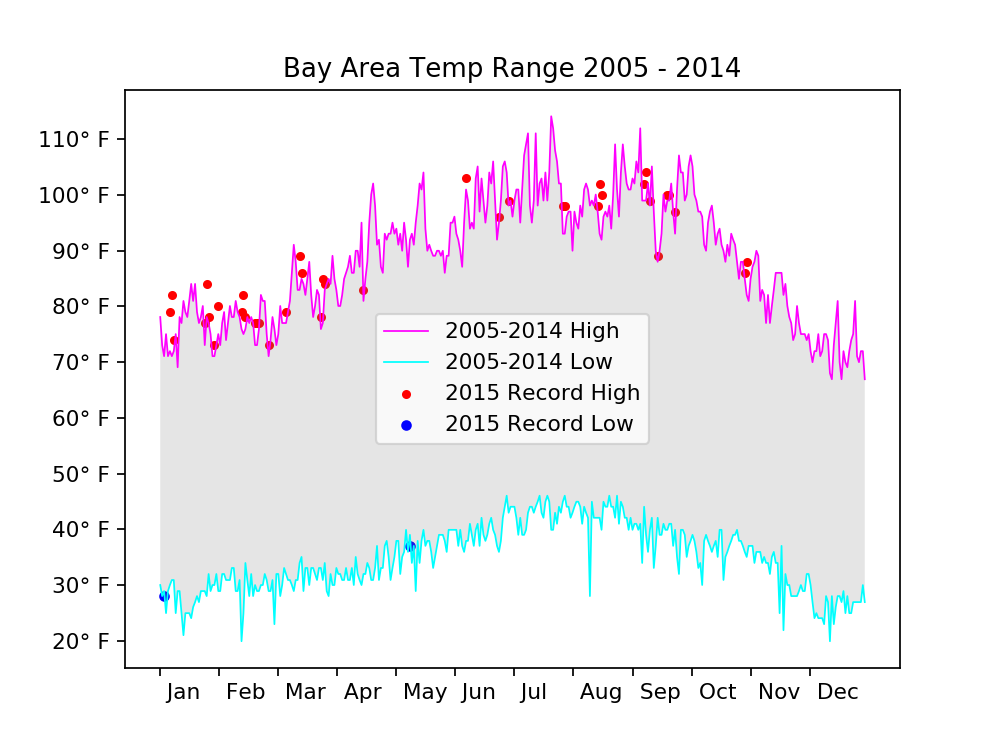

<IPython.core.display.Javascript object>


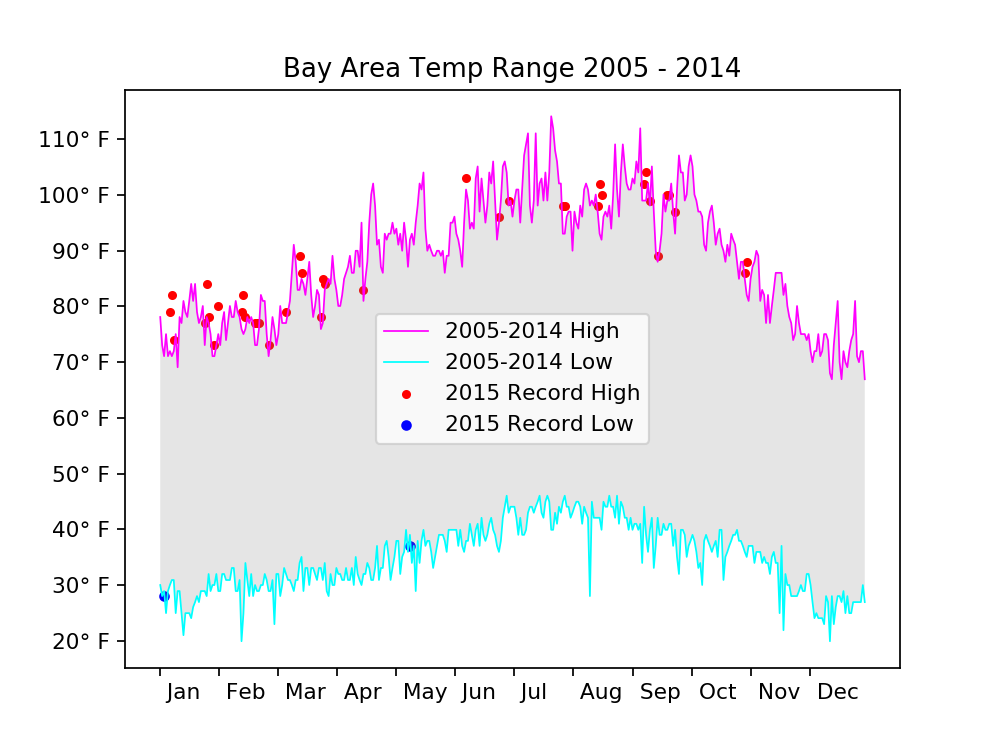

Text(0.5,1,'Bay Area Temp Range 2005 - 2014')

([<matplotlib.axis.XTick at 0x1833ea05438>,
 <a list of 12 Text xticklabel objects>)

([<matplotlib.axis.YTick at 0x1833ea0c198>,
 <a list of 10 Text yticklabel objects>)

In [19]:
# Create list of x values from data_merge index
date = ['{} {}'.format(day[0], day[1]) for day in data_merge.index.tolist()]

plt.figure()
plt.plot(date, data_merge['Tmax'], c='magenta', linewidth=0.8, label='2005-2014 High' )
plt.plot(date, data_merge['Tmin'], c='cyan', linewidth=0.8, label='2005-2014 Low', )
plt.scatter(date, data_merge['Rec-Hi'], s=10, c='red', label='2015 Record High')
plt.scatter(date, data_merge['Rec-Lo'], s=15, c='blue', label='2015 Record Low')
plt.legend()

# fill the area between the data
plt.fill_between(date, data_merge['Tmax'],data_merge['Tmin'], facecolor='grey', alpha=0.2)
    
# add a title
plt.title('Bay Area Temp Range 2005 - 2014')

# Create list of x labels from data_merge index
xlabels = [' {}'.format(mth) for mth in data_merge.index.levels[0]]
plt.xticks(range(1, 366, 30), xlabels, horizontalalignment ='left')

# Create list of y labels using degree symbol '\xb0'
ylabels = ['{}\xb0 F'.format(y) for y in range(20, 120, 10)]
plt.yticks(range(20, 120, 10), ylabels)

from matplotlib.ticker import (IndexLocator)
plt.gca().xaxis.set_major_locator(IndexLocator(base=30.5, offset=0))

In [744]:
plt.savefig('weather.png', padd_inches=0.5, bbox_inches='tight')